# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

### Utilities from fastai library

In [3]:
# from fastai.imports import *
# from fastai.structured import *

import sys
sys.path.append('/home/kaushik/Jupyter/Keras/Fastai/2018/fastai/fastai')
from imports import *
from structured import *

??parallel_trees # Calls a fuction for every tree in parallel

## Load in our data from last lesson

In [4]:
set_plot_sizes(12,14,16)

In [5]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [6]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [8]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [9]:
set_rf_samples(50000)

In [10]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20600133833574294, 0.24942837442337978, 0.91130994793762943, 0.88889344379423196, 0.89423576388070347]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.6 s, sys: 24 ms, total: 1.63 s
Wall time: 1.62 s


(9.3122220820621582, 0.27183777049986951)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 114 ms, sys: 110 ms, total: 224 ms
Wall time: 1.05 s


(9.3122220820621582, 0.27183777049986951)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

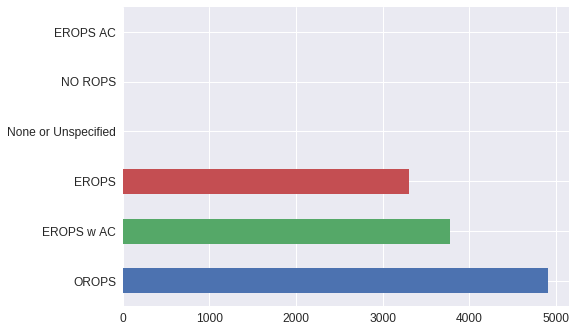

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [14]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.832028,0.276391
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.576546,0.264071
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.679168,0.224159


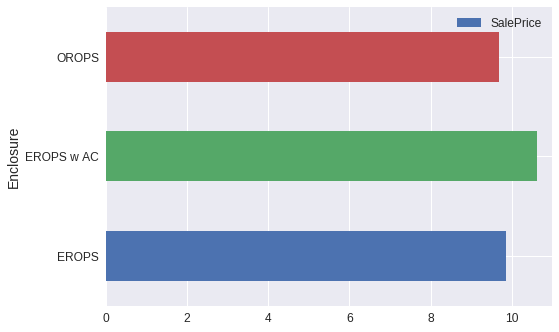

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

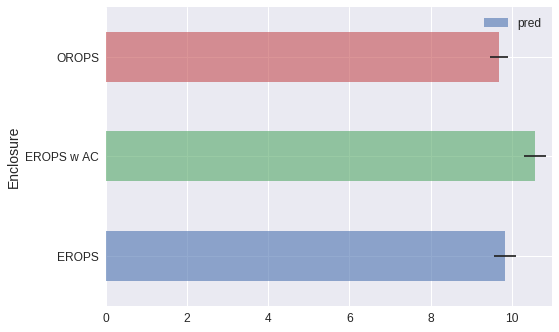

In [16]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

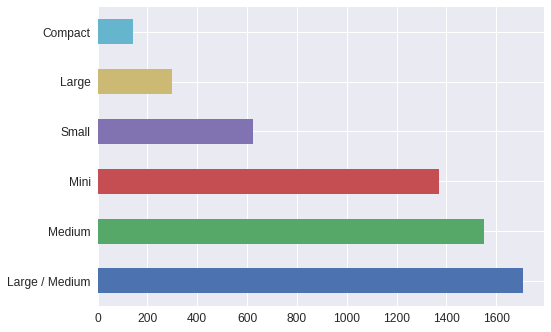

In [17]:
raw_valid.ProductSize.value_counts().plot.barh();

In [18]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.854789,0.337049
Large,10.470589,10.383959,0.365647
Large / Medium,10.691871,10.647751,0.289956
Medium,10.681511,10.622248,0.285081
Mini,9.535147,9.553103,0.243337
Small,10.324448,10.316023,0.318714


In [19]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.035213
Compact           0.034202
Small             0.030895
Large / Medium    0.027232
Medium            0.026838
Mini              0.025472
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [20]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.174500
37,Coupler_System,0.106954
13,ProductSize,0.098794
14,fiProductClassDesc,0.087291
2,ModelID,0.059833
63,saleElapsed,0.051023
38,Grouser_Tracks,0.049482
19,Enclosure,0.039450
10,fiSecondaryDesc,0.038966
39,Hydraulics_Flow,0.034586


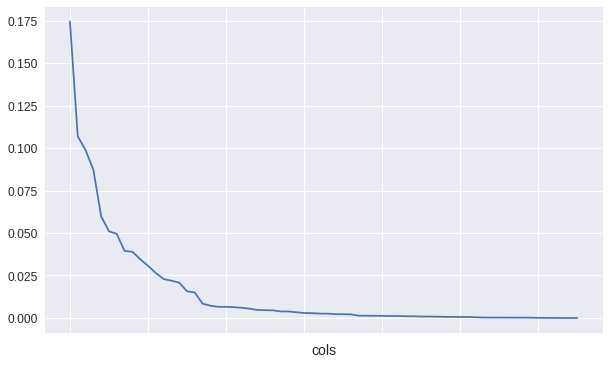

In [21]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [22]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

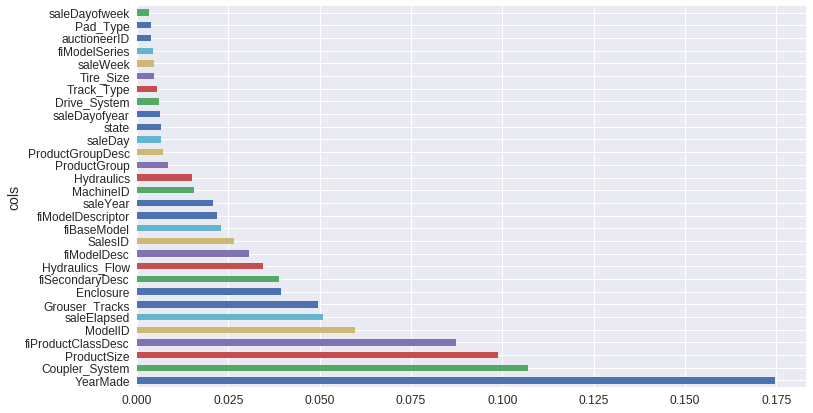

In [23]:
plot_fi(fi[:30]);

In [24]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [25]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20716067885424924, 0.24603960580109135, 0.91030887382747683, 0.89189195367634011, 0.893909895879204]


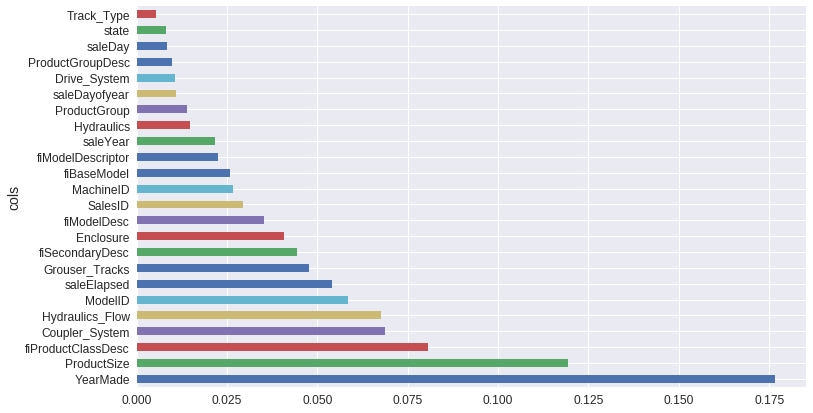

In [27]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

This feature importance plot is much more believable, because it would have less collinearity than the original model, since we have taken away less important features.

## One-hot encoding

*** Note: *** Random forest, unlike other techniques, does not necessarily need one-hot encoding, because it does not assume linear relationship and hence it can directly work with categorical variables. However, having categorical variables one-hot encoded might be more efficient even in random forest. Refer to ML1 Lesson4 00:41:00.

Also, since colliearity is not as big a problem in random forest (since it does not assume linear relationship in the first place), having (c-1) variables after one-hot encoding (where c is the number of categories in a categorical variable) in order to avoid multi-collinearity problem in random forest is not necessary. In fact, having all c variables might make random forest make more efficient, since the model wouldn't have to take multiple decisions to reach the omitted variable. 

In [28]:
# Convert any variable that has less than 7 levels into one-hot encoding
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2078710988109939, 0.25465948715940195, 0.90969266015588857, 0.88418423123715506, 0.89186527456817455]


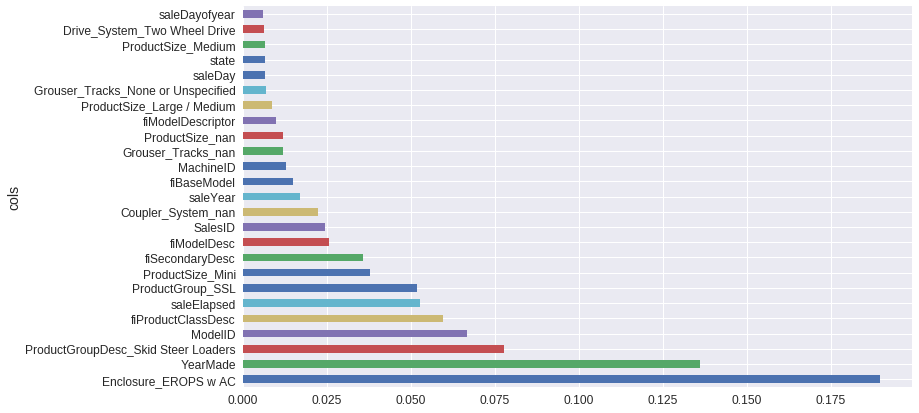

In [29]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [30]:
from scipy.cluster import hierarchy as hc

** Note: ** Random forest cares about order, and not about linearity. Hence rank correlation is used below. Please refer to ML1 Lesson 4 01:00:00.

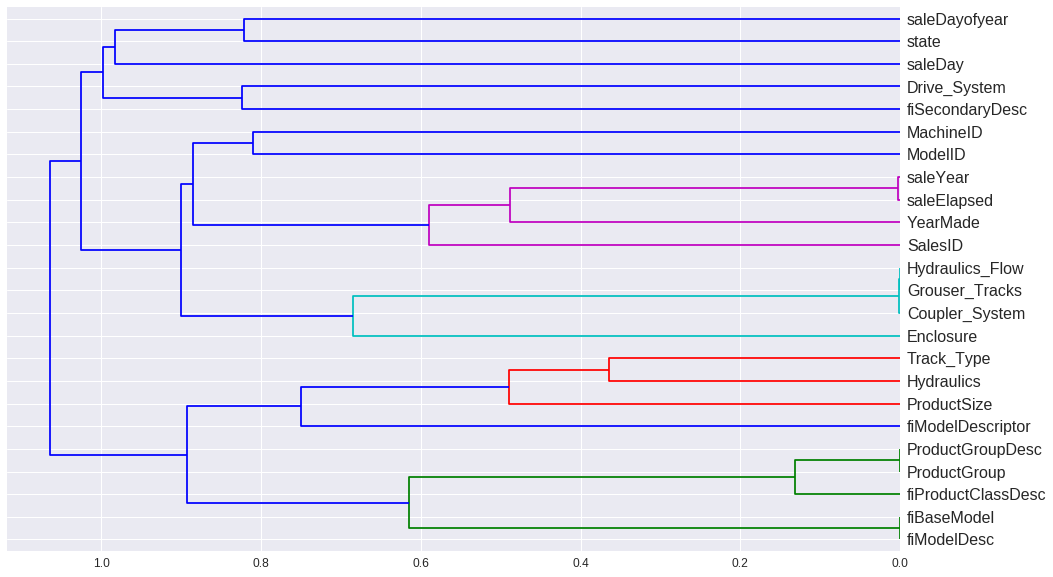

In [31]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [32]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [33]:
get_oob(df_keep)

0.88994770632972764

Now we try removing each variable one at a time.

In [34]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.888895375528
saleElapsed 0.88606559762
fiModelDesc 0.888110969454
fiBaseModel 0.889287932803
Grouser_Tracks 0.889277082982
Coupler_System 0.889849394189


It looks like we can try one from each group for removal. Let's see what that does.

In [35]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.88868499770905296

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [36]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [37]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [38]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [39]:
reset_rf_samples()

In [40]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12585264277860297, 0.22775493998000243, 0.96689759822587196, 0.90736319136233234, 0.90867493860226367]


# Partial dependence

Look for Simpson's paradox.

*** Refer to ML1 Lesson4 01:12:00 for an excellent explanation of partial dependence and all the below code. ***

In [41]:
from pdpbox import pdp
from plotnine import *

In [42]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [43]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

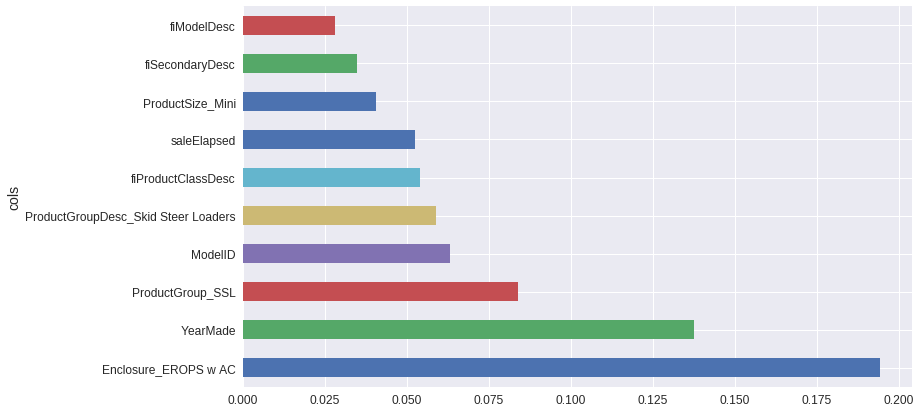

In [44]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

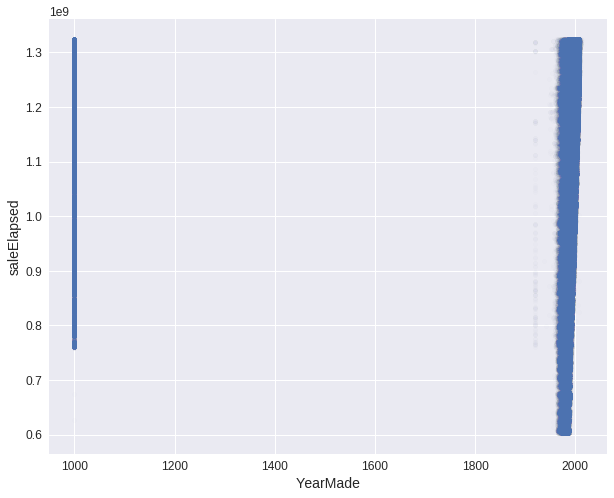

In [45]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [46]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500) # Took sampling for better visibility

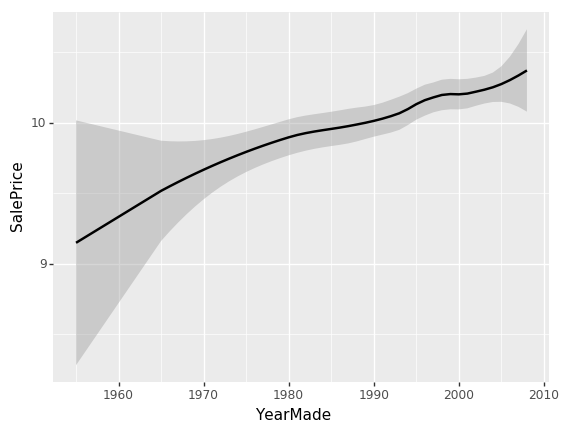

<ggplot: (-9223363248368950254)>

In [47]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess') 

In [48]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [49]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

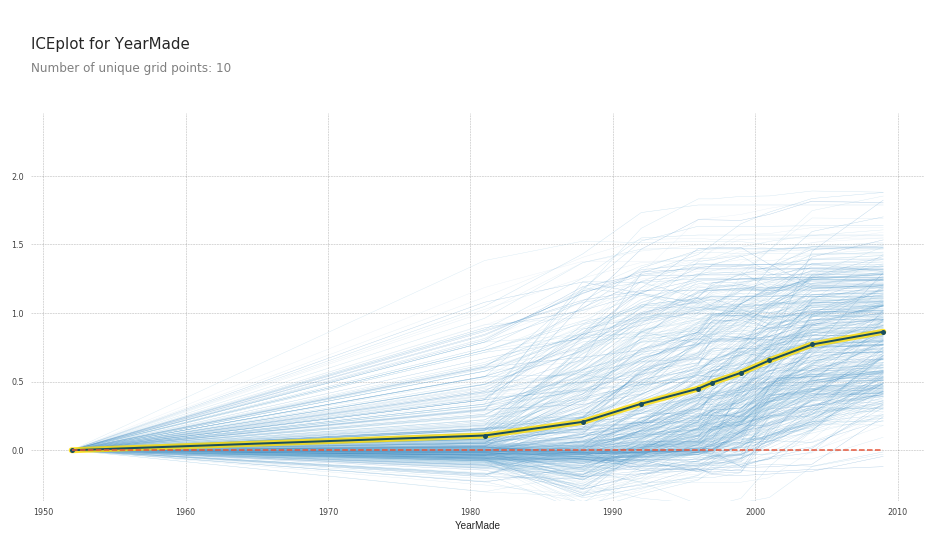

In [50]:
plot_pdp('YearMade')

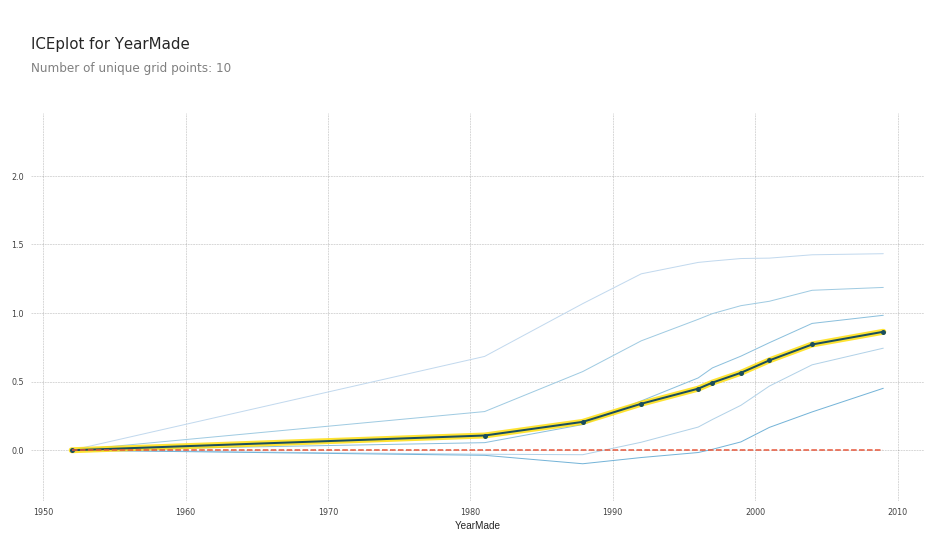

In [51]:
plot_pdp('YearMade', clusters=5)

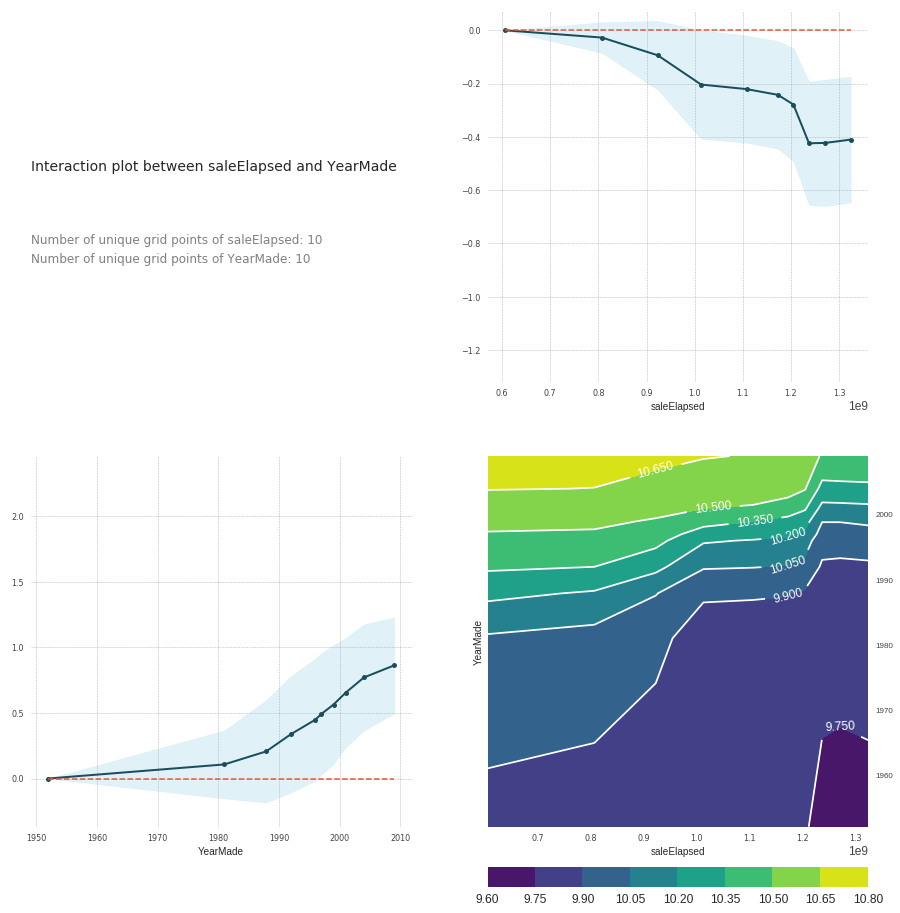

In [52]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

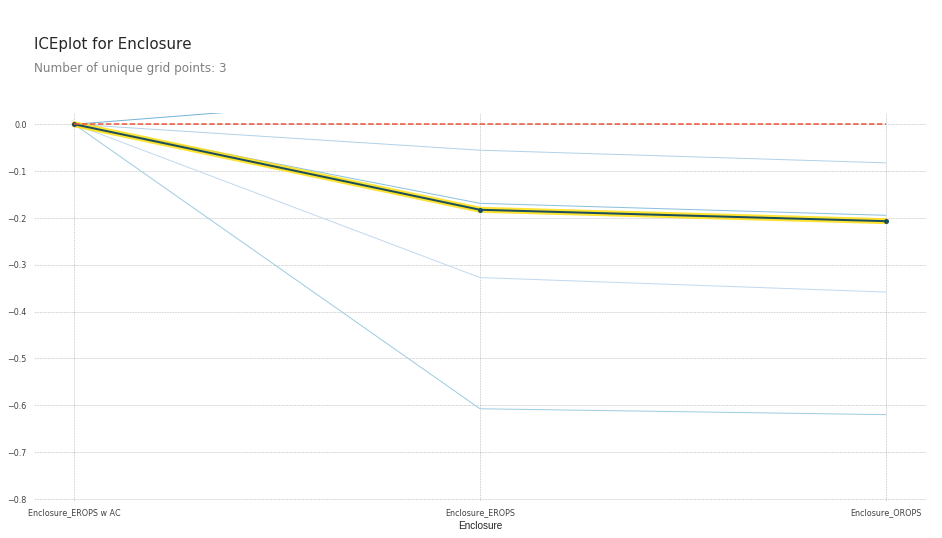

In [53]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], clusters=5, feat_name='Enclosure')

In [54]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

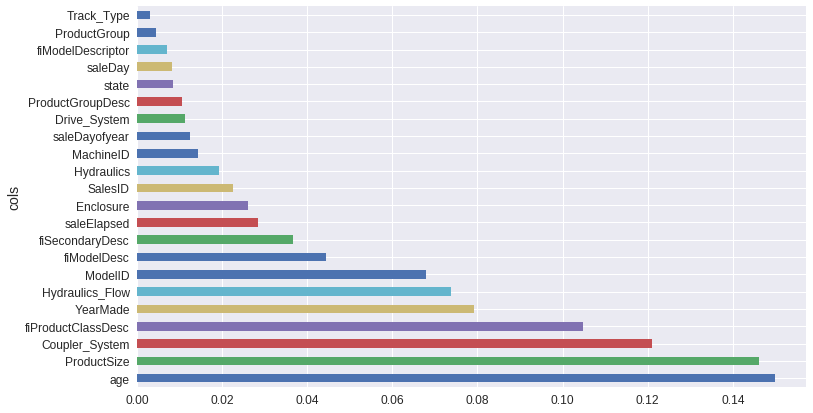

In [55]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

Look at how the random forest is doing in predicting single observations, and NOT the whole validation set as such.
Refer to ML1 Lesson5 00:40:00 for an excellent explanation.

In [56]:
from treeinterpreter import treeinterpreter as ti
import waterfall_chart

In [57]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [58]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          1,          0,
                 0,       3232,    4364751,          0,    2300944,         12,          4,          4,
                16,         35,        259,          0,          2,         11]])

In [59]:
# prediction: prediction for the row
# bias: average value (of target) across all rows
# contributions: contributions (to target) from each independent variable for the particular row
prediction, bias, contributions = ti.predict(m, row)

In [60]:
prediction[0], bias[0]

(9.347718456540548, 10.105291711979403)

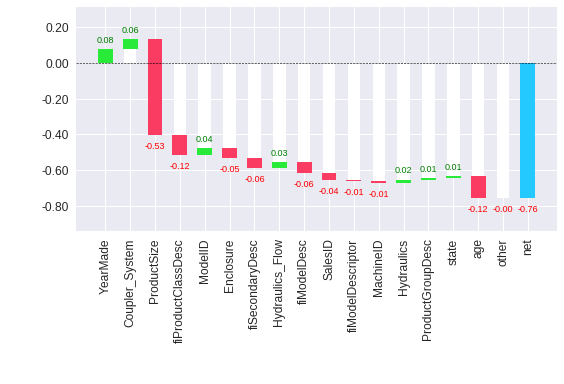

In [61]:
# Let's create a waterfall chart
contr = [contributions[0][i] for i in range(len(contributions[0]))]
colnames = df_train.columns.values
_ = waterfall_chart.plot(colnames, contr, rotation_value=90, threshold=0.01, formatting='{:,.2f}')

In [62]:
idxs = np.argsort(contributions[0])

In [63]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.53258953055133484),
 ('age', 11, -0.1206044056103929),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11537314240356493),
 ('fiModelDesc', 'KX1212', -0.061152865814603621),
 ('fiSecondaryDesc', nan, -0.059335185659605869),
 ('Enclosure', 'EROPS', -0.053279709101527704),
 ('SalesID', 4364751, -0.036007952528191466),
 ('MachineID', 2300944, -0.013892048957130143),
 ('fiModelDescriptor', nan, -0.006562129778740022),
 ('saleDay', 16, -0.0028583485138190755),
 ('saleDayofyear', 259, -0.0017025994269364464),
 ('saleElapsed', 1284595200, -0.0011252884811425723),
 ('Drive_System', nan, 0.0),
 ('Track_Type', 'Steel', 0.00165958825026018),
 ('ProductGroup', 'TEX', 0.0019823649272418644),
 ('ProductGroupDesc', 'Track Excavators', 0.0078195094724473162),
 ('state', 'Ohio', 0.01059751169998826),
 ('Hydraulics', 'Standard', 0.019338222736492484),
 ('Hydraulics_Flow', nan, 0.034429903512328594),
 ('ModelID', 665, 0.040190575241698001)

In [64]:
contributions[0].sum() # = prediction[0] - bias[0]

-0.75757325543885445

In [65]:
prediction[0] - bias[0]

-0.75757325543885479

# Extrapolation

Idea is to improve validation score by generalizing more. Refer to ML1 Lesson5 00:52:00.
If there are some variables in training set that are inherently capturing the fact that validation set is temporally different from training set, then if we can get rid of those variables, we might get better generalization and hence better validation accuracy. Please note that OOB score may not get improved by this approach since OOB data is chosen randomly, and hence there is no time dependence.

This technique can also be used to know whether test set is random or is there some time dependency (especially in Kaggle kind of competitions) - by combining training set and test set into a new training set, and try to predict a new feature (e.g. "is_valid" as in below code) which is True only in test set but False in training set.

In [66]:
# Introduce a new feature which is valid only for validation set
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [67]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

So we can certainly see that there is time dependency, since we could predict "is_valid" so well.

In [68]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.822659
5,saleElapsed,0.114881
12,MachineID,0.052606
18,saleDayofyear,0.003003
9,fiModelDesc,0.002607
0,YearMade,0.001102
4,ModelID,0.000889
7,fiSecondaryDesc,0.000743
8,Hydraulics_Flow,0.000410
1,Coupler_System,0.000358


In [69]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [70]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [71]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


Let's drop these features and see whether we can still live with.

In [72]:
x.drop(feats, axis=1, inplace=True)

In [73]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.97850296042380802

Looks like even if we remove these variables from our model, we still got pretty decent OOB score - and the validation score will improve due to better generalization.

Let's now see whether there are more variables which contribute to time dependency, and if so, remove them.

In [74]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.242855
0,YearMade,0.188430
15,saleDayofyear,0.152684
4,ModelID,0.073269
8,fiModelDesc,0.064821
13,saleDay,0.060072
14,state,0.054396
3,fiProductClassDesc,0.033365
6,fiSecondaryDesc,0.024304
5,Enclosure,0.021358


In [75]:
set_rf_samples(50000)

In [76]:
# Set of all temporal features that we would like to remove
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [77]:
# This is our benchmark, before removing any variables
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2081216353876395, 0.24939003374880347, 0.90947484318697924, 0.88892759847227221, 0.89292760610171107]


In [78]:
# Let's remove these features one by one, and construct corresponding models to see the effects
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20932627230243472, 0.24574215964654528, 0.90842386601661396, 0.89215318710728009, 0.89232367793920708]
saleElapsed
[0.21450210226542202, 0.25601245690891633, 0.90383923007158462, 0.88295033664967981, 0.88675428810108148]
MachineID
[0.2075923349596398, 0.24650536909810092, 0.90993470959929112, 0.8914822601242095, 0.89421158268873202]
age
[0.2091753560448787, 0.24775383785503818, 0.90855586421546219, 0.89038026310308427, 0.89206578264126024]
YearMade
[0.20903006036587185, 0.2518148366132367, 0.90868285645386571, 0.8867571989113352, 0.89224209248453312]
saleDayofyear
[0.20873296194314167, 0.24483645659266287, 0.90894225358504344, 0.89294667886507684, 0.89302877592133034]


Variables which improved validation accuracy upon removal, but did not decrese the OOB score, are tthe ones that are truly time dependent variables, and don't add much to our model - hence should be removed.

Comparing the above results to our previous benchmarking results, we see that these variables are:
- SalesID
- MachineID
- saleDayofyear

In [79]:
reset_rf_samples()

In [80]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1386731007473376, 0.21742411981173893, 0.95980988219778351, 0.91557648790925916, 0.90940154035401144]


And now our validation score is better than OOB score.

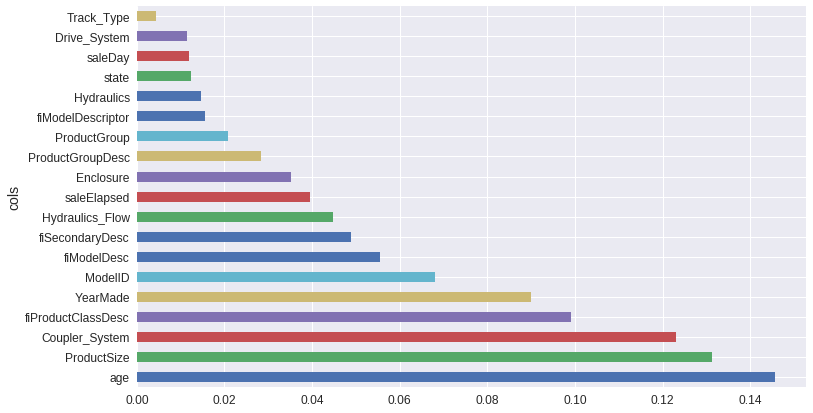

In [81]:
plot_fi(rf_feat_importance(m, X_train));

In [82]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Hyperparameter tuning

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.3s finished


This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


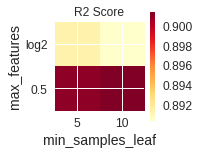

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)


In [84]:
# https://medium.com/mlreview/parfit-hyper-parameter-optimization-77253e7e175e
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid

paramGrid = ParameterGrid({
    'min_samples_leaf': [5,10],
    'max_features': ['log2', 0.5],
    'n_estimators': [5],
    'n_jobs': [-1],
    'random_state': [42]
})

best_model, best_score, all_models, all_scores = pf.bestFit(m, paramGrid, 
     X_train, y_train, X_valid, y_valid, 
     metric=metrics.r2_score, scoreLabel='R2 Score')

print(best_model)

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)